In [197]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import requests
import mwparserfromhell
import urllib.request
import json
import re
import pickle
from tqdm import tqdm
import networkx as nx
from fa2 import ForceAtlas2
import numpy as np
import matplotlib.pyplot as plt
import os


In [12]:
with open('df_meta.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [29]:
with open('df.pickle', 'rb') as handle:
    df_lore = pickle.load(handle)

In [114]:
nodeList = []
edgeList = []
for index, row in df_lore.iterrows():
    char = row['Name']
    nodeList.append((char, {"Race": row['Race'], "Affiliation": row['Affiliation']}))
    for link in list(row['Out Links']):
        edgeList.append((char,link))


In [180]:
DG = nx.DiGraph()

DG.add_nodes_from(nodeList)
DG.add_edges_from(edgeList)

G = DG.to_undirected()

GCC_nodes = max(nx.weakly_connected_components(DG), key=len)
GCC = DG.subgraph(GCC_nodes).copy()
GCC_UG = GCC.to_undirected()

In [141]:
np.unique(list(nx.get_node_attributes(G, "Affiliation").values()))

array(['0', 'Alliance', 'Horde', 'Other'], dtype='<U11')

In [192]:
node_attr = nx.get_node_attributes(GCC_UG, "Affiliation")

# compute node size 
node_size = [d[1] for d in nx.degree(GCC_UG)]

# create colormap for Horde, Alliance, and other nodes
horde_nodes = [node for node in GCC_UG.nodes() if node_attr[node] == 'Horde']
alliance_nodes = [node for node in GCC_UG.nodes() if node_attr[node] == 'Alliance']
other_nodes = [node for node in GCC_UG.nodes() if node_attr[node] == 'Other' or node_attr[node] == '0']

color_map_horde = ["#E21A1A" for n in horde_nodes]
color_map_alliance = ["#1A1CE2" for n in alliance_nodes]
color_map_other = ["#9C9C9C" for n in other_nodes]

# create colormap for edges
color_a = '#E24343' # horde <-> horde
color_b = '#2350F5' # alliance <-> alliance
color_c = '#B413AF' # horde <-> alliance
color_d = '#AAAAAA' # else

edge_color = []
edge_alpha = []

for edge in GCC_UG.edges():
    from_, to_ = edge
    if node_attr[from_] == 'Horde' and node_attr[to_] == 'Horde':
        edge_color.append(color_a)
        edge_alpha.append(0.5)
    elif node_attr[from_] == 'Alliance' and node_attr[to_] == 'Alliance':
        edge_color.append(color_b)
        edge_alpha.append(0.5)
    elif node_attr[from_] == 'Alliance' and node_attr[to_] == 'Horde' or node_attr[from_] == 'Horde' and node_attr[to_] == 'Alliance':
        edge_color.append(color_c)
        edge_alpha.append(0.5)
    else:
        edge_color.append(color_d)
        edge_alpha.append(0.1)

In [146]:
# # parameters for nx.draw

# degrees = [d[1] for d in nx.degree(G)]
# color_map = []
# hex_cols = []

# # from https://stackoverflow.com/questions/13998901/generating-a-random-hex-color-in-python
# r = lambda: random.randint(0,255)
# for i in range(len(np.unique(list(part.values())))):
#     hex_col = '#%02X%02X%02X' % (r(),r(),r())
#     hex_cols.append(hex_col)

# for com in part.values():
#     color_map.append(hex_cols[com])

In [183]:
# list containing node lists for each each Louvain attribute
nodeAtsDict = {}
for att in ['Horde', 'Alliance', 'Other']:
    nodesByAts = [x for x,y in GCC_UG.nodes(data=True) if y['Affiliation']==att]
    nodeAtsDict[att]=nodesByAts

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 35.75it/s]


BarnesHut Approximation  took  2.28  seconds
Repulsion forces  took  11.04  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.24  seconds


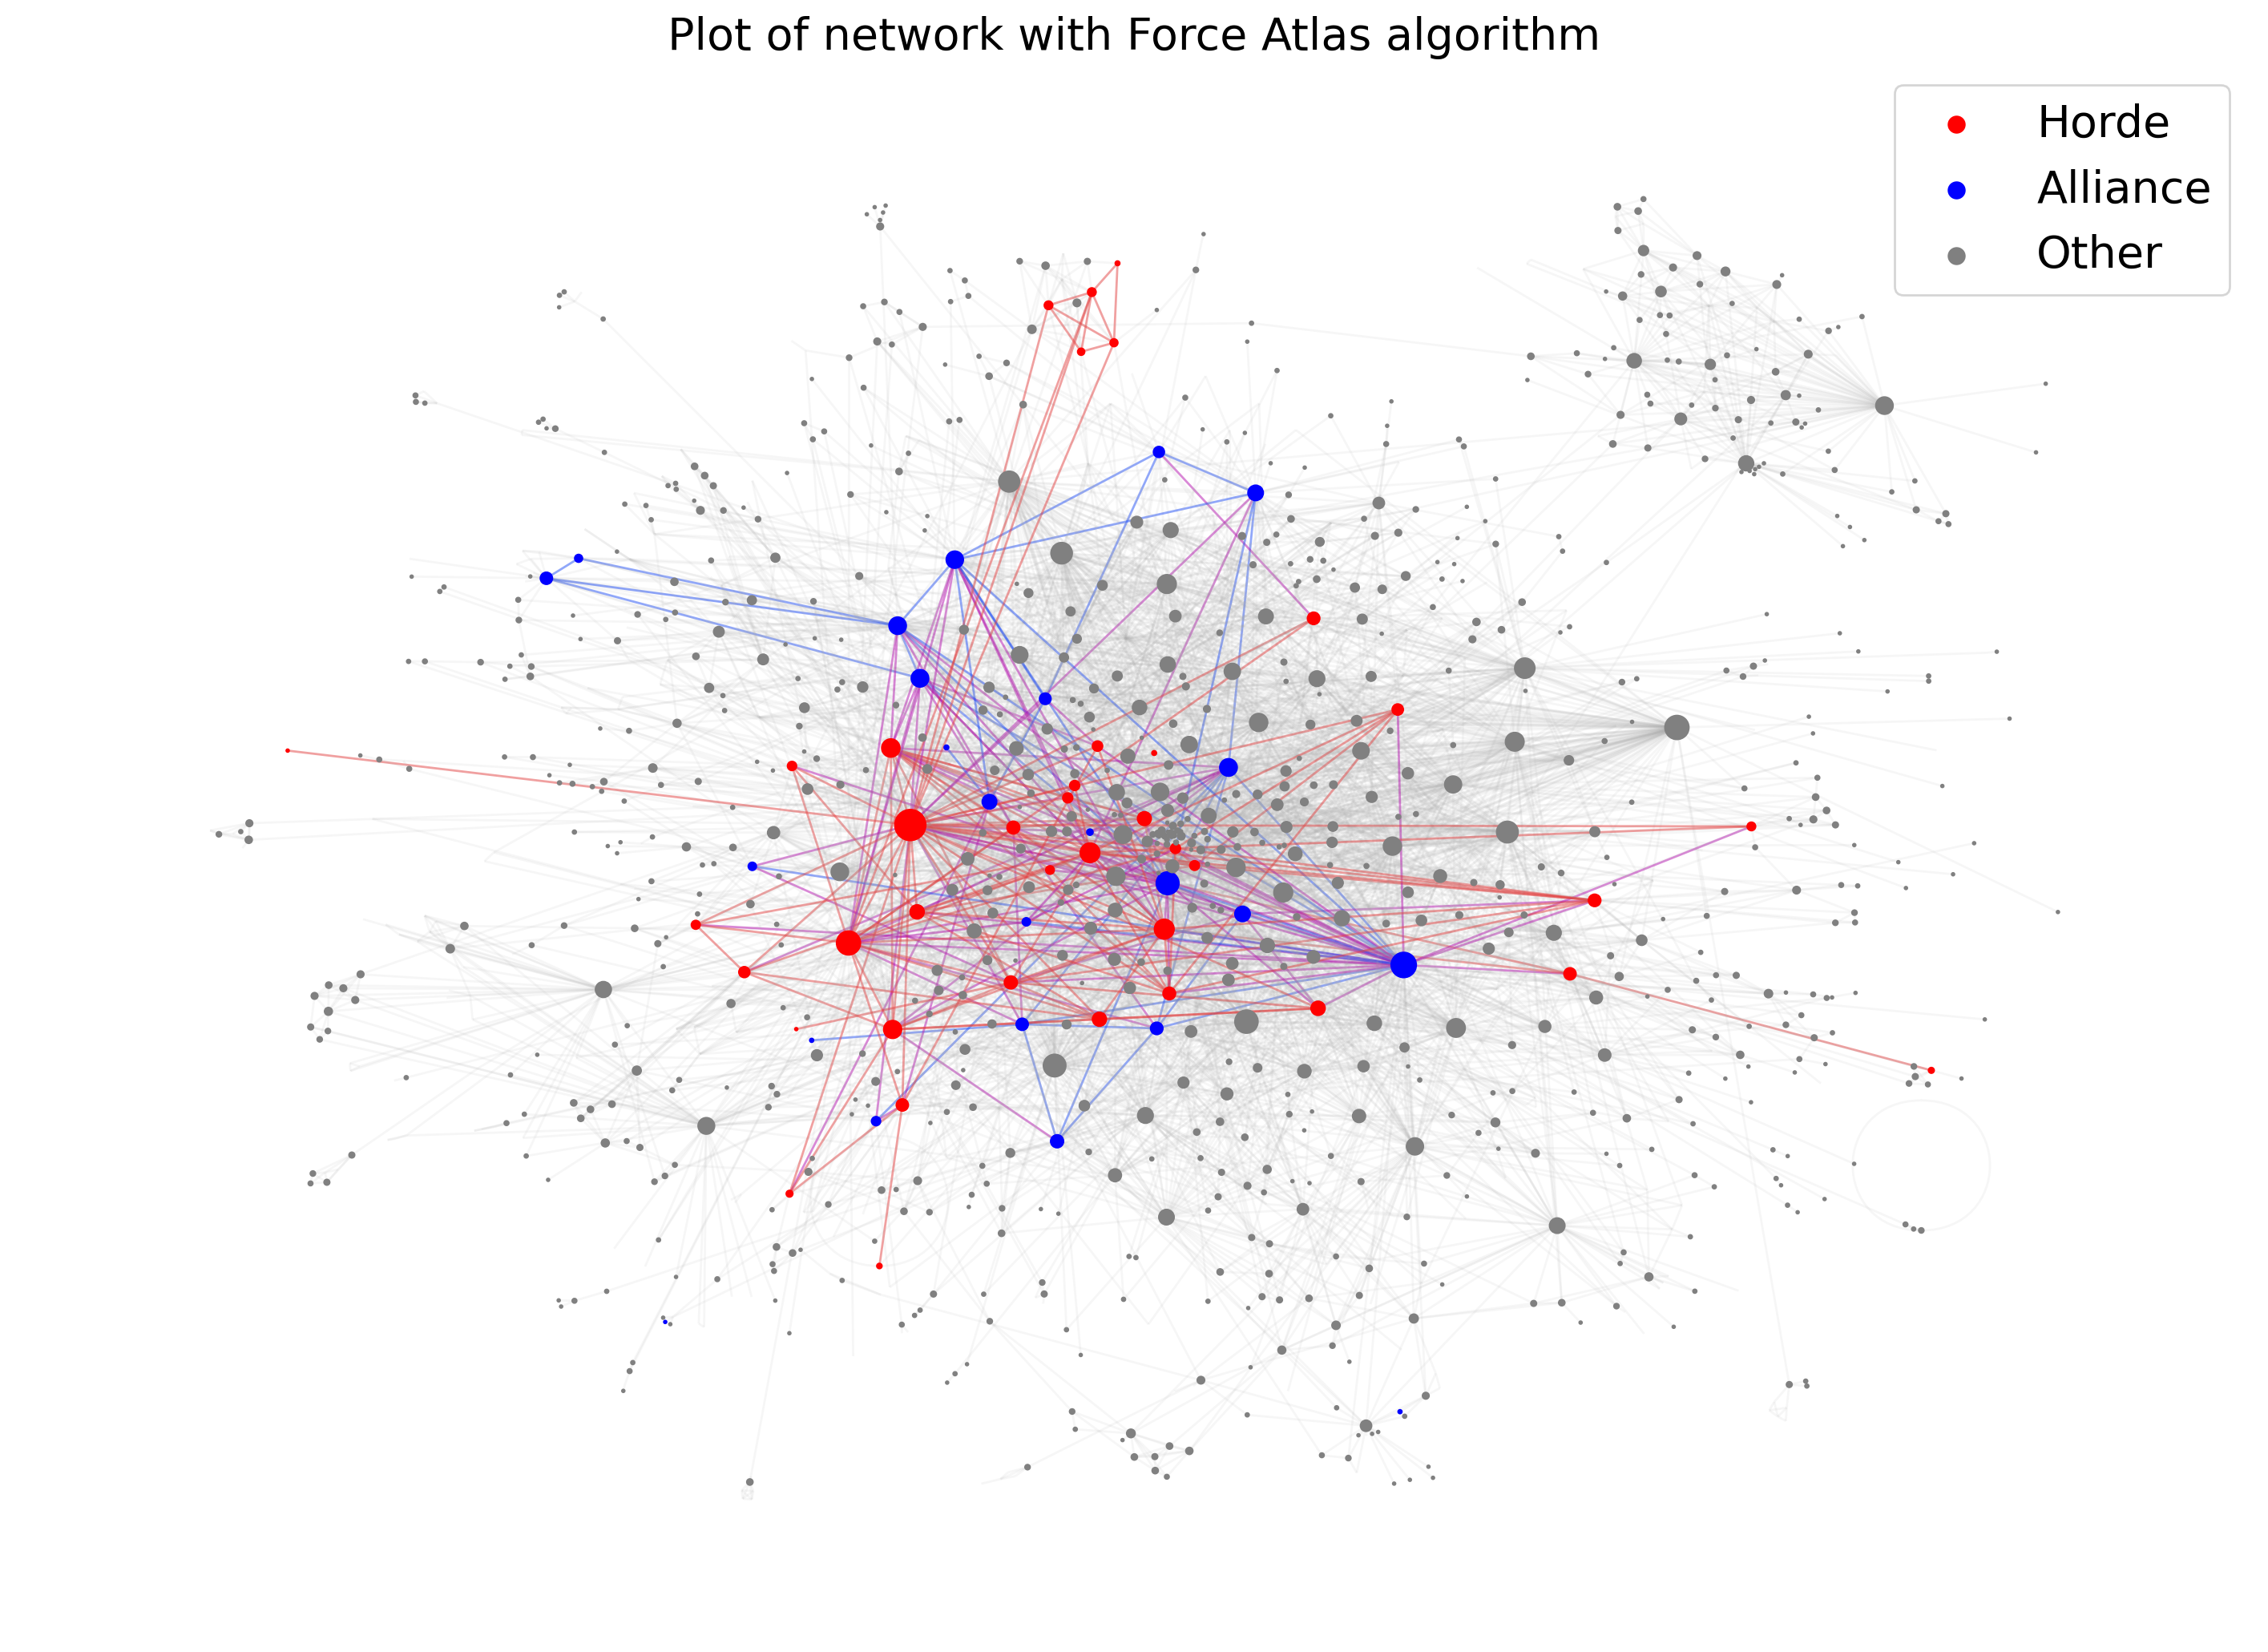

In [194]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        # Log
                        verbose=True)

fig = plt.figure(figsize=(18,13), dpi=200)
plt.title("Plot of network with Force Atlas algorithm", fontsize=20)
positions = forceatlas2.forceatlas2_networkx_layout(GCC_UG, pos=None, iterations=500)

nx.draw_networkx_nodes(GCC_UG, positions, node_size=[GCC_UG.degree()[node] for node in nodeAtsDict['Horde']], nodelist=nodeAtsDict['Horde'], node_color='red', label='Horde')
nx.draw_networkx_nodes(GCC_UG, positions, node_size=[GCC_UG.degree()[node] for node in nodeAtsDict['Alliance']], nodelist=nodeAtsDict['Alliance'], node_color='blue', label='Alliance')
nx.draw_networkx_nodes(GCC_UG, positions, node_size=[GCC_UG.degree()[node] for node in nodeAtsDict['Other']], nodelist=nodeAtsDict['Other'], node_color='grey', label='Other')
                                                          
nx.draw_networkx_edges(GCC_UG, positions, edge_color=edge_color, alpha=edge_alpha)

plt.axis('off')
lgnd = plt.legend(prop={'size': 20})
for handle in lgnd.legendHandles:
    handle.set_sizes([50.0])
plt.show()

In [200]:
filepath = os.getcwd()

with open(filepath+'\\DG.pickle', 'wb') as handle:
    pickle.dump(DG, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\G.pickle', 'wb') as handle:
    pickle.dump(G, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(filepath+'\\GCC.pickle', 'wb') as handle:
    pickle.dump(GCC_UG, handle, protocol=pickle.HIGHEST_PROTOCOL)